<a href="https://colab.research.google.com/github/divij-dawar/Character-Level-Language-Model/blob/main/Character_Level_language_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden),generator=g) * (5/3)/((n_emb * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


12297


tensor(-0.0021) tensor(0.9987)
tensor(0.0003) tensor(0.9992)


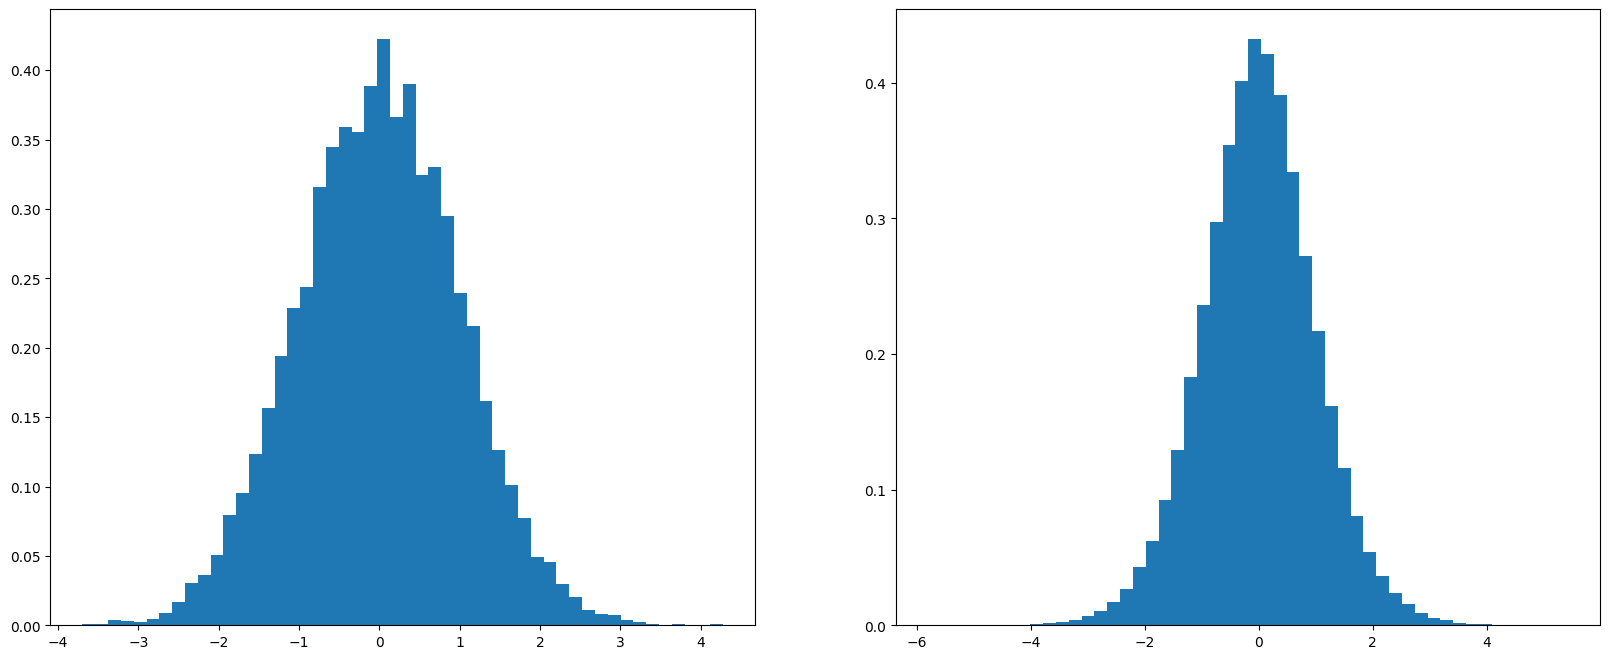

In [9]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward Pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    if p.grad is not None:
        p.data += -lr * p.grad

  # Track Stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


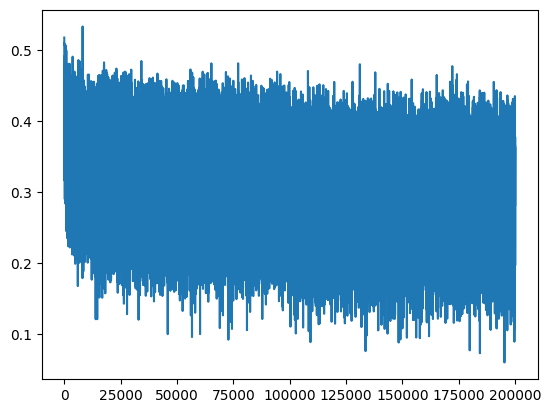

In [28]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 #+ b1
  bnmean = hpreact.mean(0,keepdim=True)
  bnstd = hpreact.std(0,keepdim=True)

In [13]:
@torch.no_grad()

def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 #+ b1
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


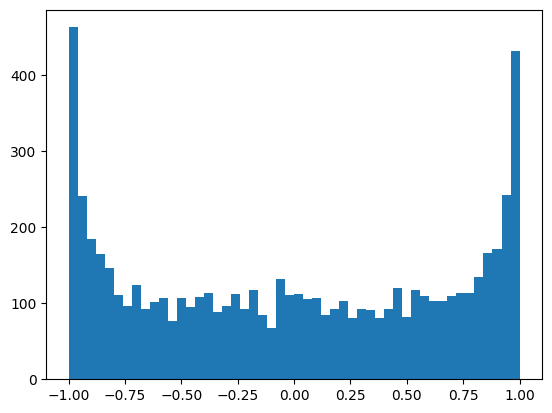

In [14]:
plt.hist(h.view(-1).tolist(),50);

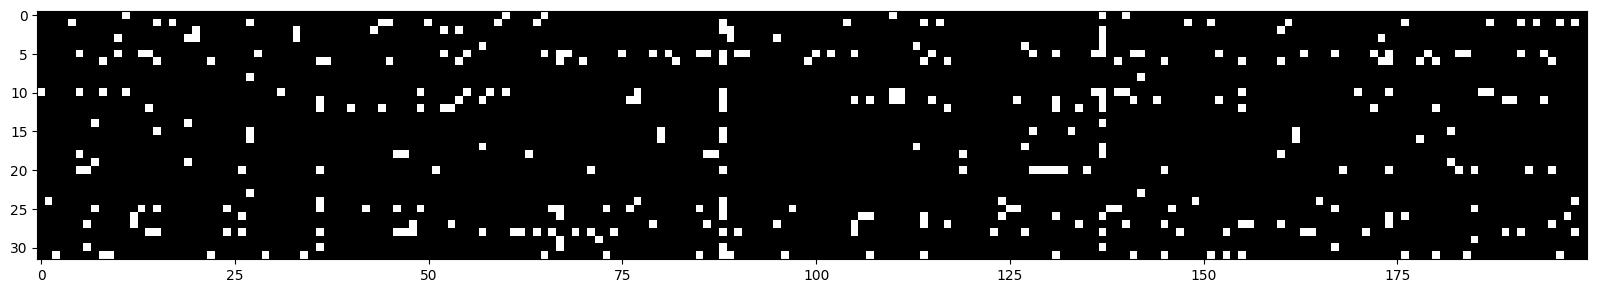

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='gray',interpolation='nearest')

In [16]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1, generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.


In [17]:
class Linear:

  def __init__(self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out), generator= g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      xmean = x.mean(0,keepdim=True)
      xvar = x.var(0,keepdim=True,unbiased=True)

    else:
      xmean = self.running_mean
      xvar = self.ruuning_var

    xhat = (x - xmean) / torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator = g)
layers = [
    Linear(n_embd * block_size,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
]


In [18]:
with torch.no_grad():
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward Pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  for layer in layers:
    layer.out.retain_grad()

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    if p.grad is not None:
        p.data += -lr * p.grad

  # Track Stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2962
  10000/ 200000: 2.3341
  20000/ 200000: 2.0329
  30000/ 200000: 1.7318
  40000/ 200000: 2.1077
  50000/ 200000: 2.2374
  60000/ 200000: 1.8726
  70000/ 200000: 2.1199
  80000/ 200000: 2.4593
  90000/ 200000: 1.8261
 100000/ 200000: 2.3135
 110000/ 200000: 2.1903
 120000/ 200000: 2.0297
 130000/ 200000: 1.9963
 140000/ 200000: 1.6833
 150000/ 200000: 1.6654
 160000/ 200000: 1.8643
 170000/ 200000: 1.6911
 180000/ 200000: 2.1671
 190000/ 200000: 1.9262


layer 1 (      Tanh): mean -0.05, std 0.87, saturated: 49.38%
layer 3 (      Tanh): mean -0.02, std 0.89, saturated: 53.66%
layer 5 (      Tanh): mean -0.01, std 0.91, saturated: 57.78%
layer 7 (      Tanh): mean -0.06, std 0.92, saturated: 58.28%
layer 9 (      Tanh): mean +0.03, std 0.84, saturated: 36.47%


Text(0.5, 1.0, 'activation distribution')

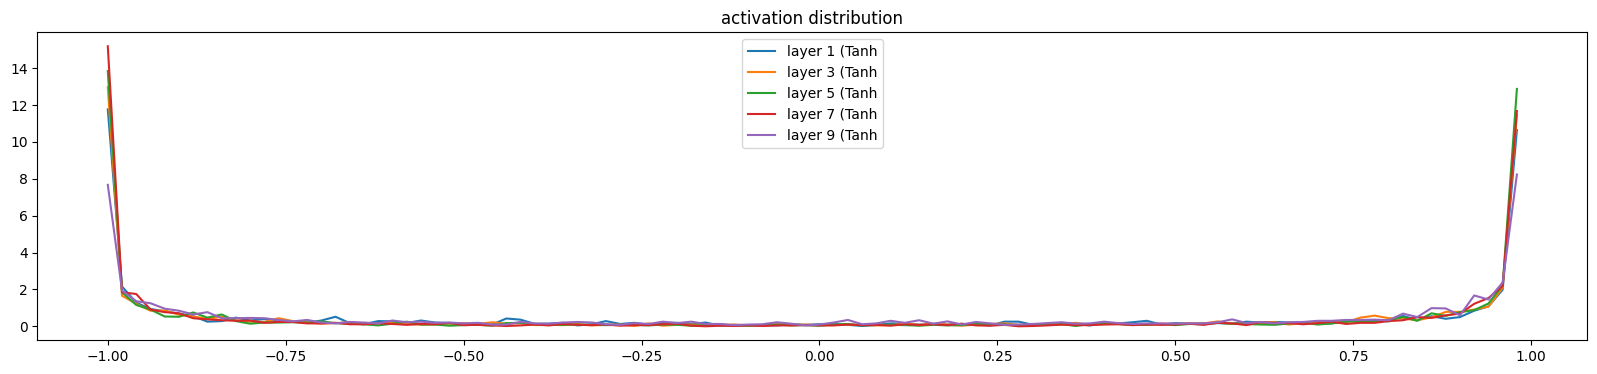

In [20]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000046, std 3.338039e-03
layer 3 (      Tanh): mean -0.000073, std 3.114085e-03
layer 5 (      Tanh): mean +0.000015, std 3.855027e-03
layer 7 (      Tanh): mean -0.000101, std 4.185649e-03
layer 9 (      Tanh): mean -0.000098, std 4.795169e-03


Text(0.5, 1.0, 'gradient distribution')

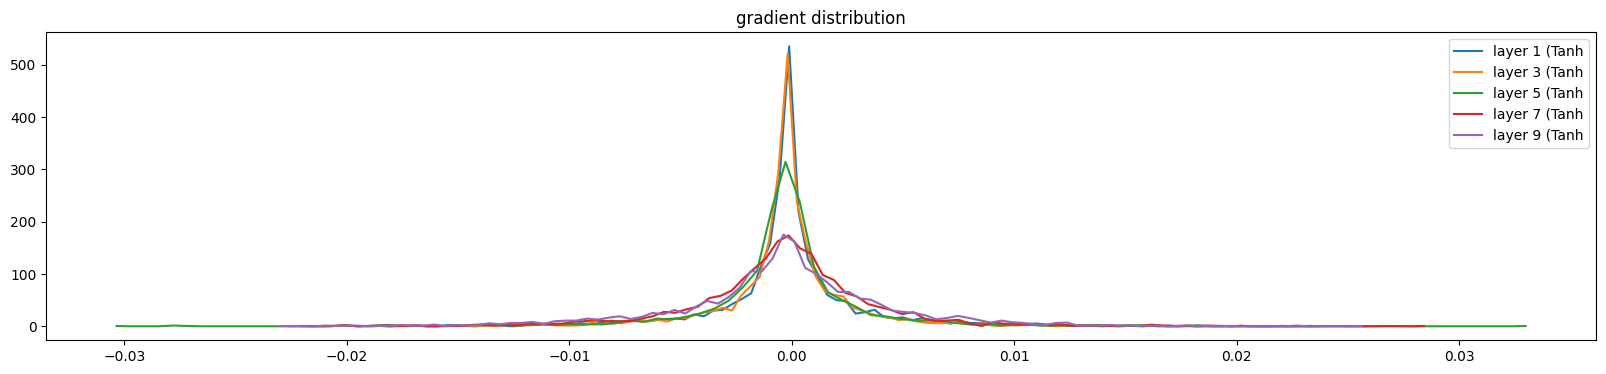

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000119 | std 1.406674e-02 | grad:data ratio 1.187448e-02
weight  (30, 100) | mean -0.000115 | std 8.753325e-03 | grad:data ratio 1.864465e-02
weight (100, 100) | mean -0.000071 | std 5.620585e-03 | grad:data ratio 2.011437e-02
weight (100, 100) | mean +0.000095 | std 5.715128e-03 | grad:data ratio 2.118429e-02
weight (100, 100) | mean -0.000051 | std 6.941903e-03 | grad:data ratio 2.619632e-02
weight (100, 100) | mean +0.000009 | std 8.082917e-03 | grad:data ratio 3.469447e-02
weight  (100, 27) | mean -0.000000 | std 2.234427e-02 | grad:data ratio 1.153556e-01


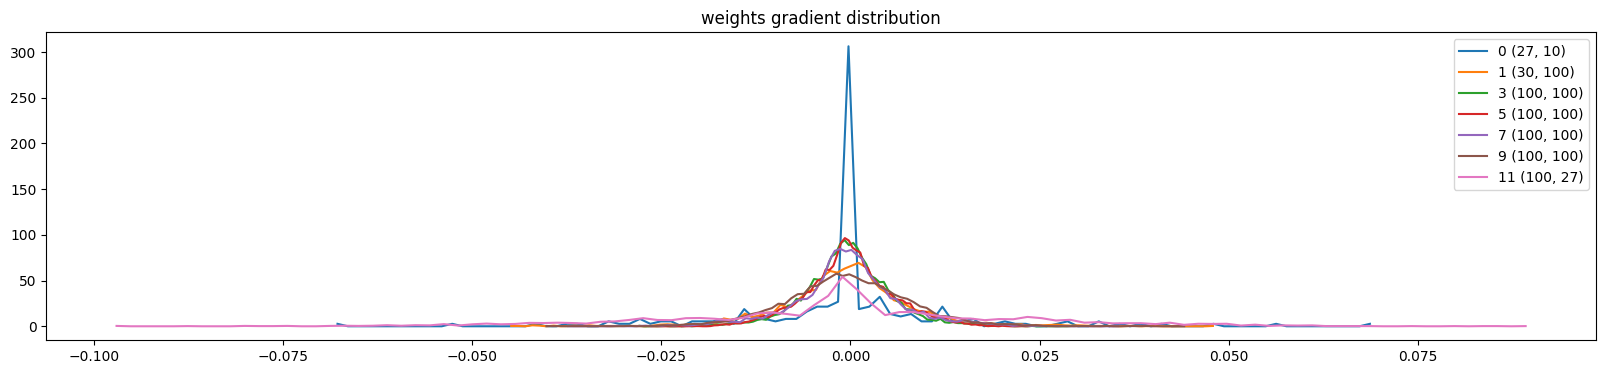

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');